# A first guide to use CRISPRzip-model

This notebook gives a basic idea how users would be able to interact with CRISPRzip-model, at least in the first phase of the project.


In [1]:
import json

import matplotlib.pyplot as plt

from czmodel.kinetics import *
from czmodel.plotting import SearcherPlotter

## User input
As a starting point, the user would provide the guide RNA sequence (or really, the DNA protospacer sequence, though it is easy to go between them) and a list of potential off-targets. Later, we could automatically identify targets on a gene, or a full genome, and even later, we might be able to scan for potential targets in a specified gene/region.

In [2]:
# specify protospacer (=guide RNA) and target DNA
guide_rna   =   "GACGCATAAAGATGAGACGC"     # 5'-to-3'
protospacer =  "AGACGCATAAAGATGAGACGCTGG"  # 5'-to-3', with 5' flanking NT and 3' PAM (NGG)
targets     = [protospacer,                # the on-target sequence and ...
               "AGACCCATTAAGATGAGACGCGGG", # ... a few different off-targets with some point mutations
               "AGACGCATAACTATGAGACGCAGG",
               "AGACGCATAAAGATGAGACGCGGG",
               "AGACGCATAAAGATAAGCGGCCGG"]

In [3]:
# loading a parameter set for the energy landscape model
with open('bare_protein_params.json', 'r') as file:
    bare_protein_params = json.load(file)

bare_protein = BareSearcher(**bare_protein_params)
guided_protein = bare_protein.bind_guide_rna(protospacer)
protein_target_complexes = [guided_protein.probe_sequence(target_seq)
                            for target_seq in targets]

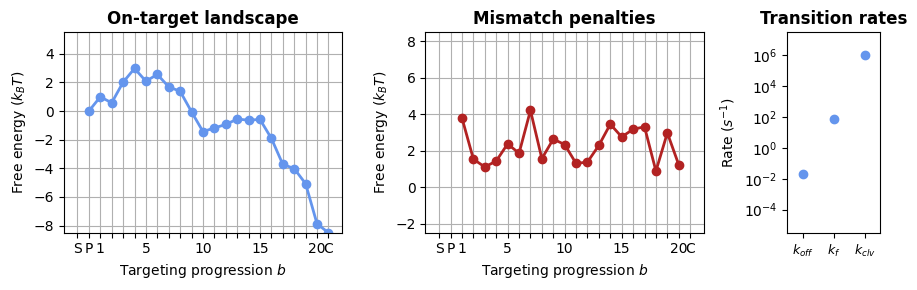

In [6]:
# visualizing the parameter set that defines the energy model
%matplotlib inline
fig, axes = plt.subplots(1, 3, figsize=(9, 3), width_ratios=(3, 3, 1))
SearcherPlotter(bare_protein).plot_on_target_landscape(axs=axes[0], y_lims=(-8, 5))
SearcherPlotter(bare_protein).plot_mismatch_penalties(axs=axes[1], y_lims=(-2, 8))
SearcherPlotter(bare_protein).plot_internal_rates(axs=axes[2], y_lims = (1E-5, 1E7))
plt.tight_layout()

## Predicting cleavage rates
With this functionality, a user can predict the probability that a DNA sequence is cleaved. This depends both on concentration and on exposure time, so these parameters could be implemented as an interactive slider. Also, I could calculate the cleavage vs time curve and plot that for an individual or for a few DNA targets.

In [7]:
k_on_ref = 1E-2  # default parameter: k_on at 1 nM (Hz)

# user input
concentration = 5  # nM
time = 600 # s (= 10 mins)

binding_rate = k_on_ref * concentration
f_clv = [stc.get_cleaved_fraction(time, binding_rate)
         for stc in protein_target_complexes]


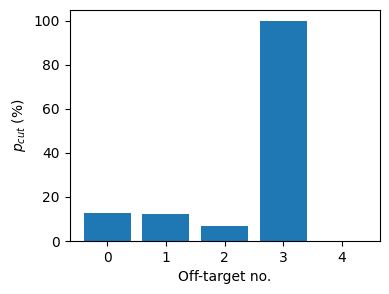

In [8]:
_, axs_clv = plt.subplots(1, 1, figsize=(4, 3))
axs_clv.bar(np.arange(len(protein_target_complexes)),
        np.array(f_clv) * 100, .8)
axs_clv.set_xlabel("Off-target no.")
axs_clv.set_ylabel(r"$p_{cut}$ (%)")
plt.show()

## Predicting binding constants
With this functionality, a user can predict the probability that a DNA sequence is bound. This depends strongly on concentration (and somewhat on exposure time), so these parameters could be implemented as an interactive slider.

In [9]:
# user input
concentration = 5  # nM
time = 600 # s (= 10 mins)

binding_rate = k_on_ref * concentration
f_bnd = [stc.get_bound_fraction(time, binding_rate)
         for stc in protein_target_complexes]


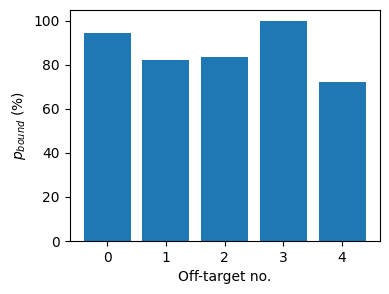

In [10]:
_, axs_bnd = plt.subplots(1, 1, figsize=(4, 3))
axs_bnd.bar(np.arange(len(protein_target_complexes)),
        np.array(f_bnd) * 100, .8)
axs_bnd.set_xlabel("Off-target no.")
axs_bnd.set_ylabel(r"$p_{bound}$ (%)")
plt.show()

## Other
There are a few other features I could add relatively easily:
- Visualizing the energy landscape of a protein-target complex
- Visualizing a coarse-grained version of the full energy landscape
- Generating cleavage and binding curves as a function of time and concentration
- Doing statistics on the cleavage/binding characteristics of the off-target sequences (tables, histograms, etc.)